# Variational inference: an introduction using PyMC3



## 0.1 An introduction to variational inference methods

In the past chapters we have seen how to perform Bayesian inference using MCMC-based techniques. These methods are incredibly powerful and fully characterize the posterior distribution no matter how complicated that distribution may be. One important drawback of these methods though is the computational burden associated with sampling and the associated convergence limits.

With variational inference instead, the basic idea is to pick an approximation $q(x)$ to the posterior distribution from some tractable family, and then try to make this approximation as close as possible to the true posterior, i.e.:

\begin{align}
p^{*}(x) = p(x/D)
\end{align}

to effectively reduce inference to an optimization problem.

The key idea is to introduce a family of distributions over the latent variables $z$ that depends on variational parameters $\lambda$, [$q(z/\lambda)$], and find the values of $\lambda$ that minimize the KL divergence between $q(z/\lambda)$ and $p(z/x)$. The most common model used in this context is the mean field approximation, where $q$ factors into conditionally independent distributions each governed by a set of parameters (represented here by $\lambda$):

\begin{align}
q(z/\lambda) = \prod ^{m} _{j=1} q_j(z_j / \lambda)
\end{align}

Minimizing the KL divergence between $q(z/\lambda)$ and $p(z/x)$ i.e. roughly said, making these distributions as 'close'/similar as possible is equivalent to maximizing the Evidence Lower Bound (ELBO), calculated as:

\begin{align}
L(\lambda) = E[logp(x,z) - logq(z)]
\end{align}

calculated w.r.t $q(z)$.

We just need to maximize this expression to find the parameters \lambda that make the KL divergence small and our $q(z/\lambda)$ very similar to $p(z/x)$. So where is the catch? Deriving gradients for complex functions is a tedious process, and for sure it is one that cannot be easily automated.

We can solve this problem by using the “black box” variational model reported in this [1] paper: "From the practitioner’s perspective, this method requires only that he or she write functions to evaluate the model log-likelihood. The remaining calculations (properties of the variational distribution and evaluating the Monte Carlo estimate) are easily put into a library to share across models, which means our method can be quickly applied to new modeling settings."

Let us see how this works: the key idea from the publication is that we can write the gradient of the ELBO as an expectation:

\begin{align}
\Delta_{\lambda}L(x) = E_q[\Delta_{lambda}logq(z/\lambda) * (log(p, z) - logq(z/\lambda))]
\end{align}

And here come the good part: we can use Monte Carlo to obtain a noisy estimate of this gradient expression: we initialize the model parameters $\lambda$ (randomly), we sample from $q(z/\lambda)$, we evaluate the entire expression (see below) and take the mean over different samples. We then use stochastic gradient descent to optimize (maximize) the ELBO!

Fortunately, we do not have to perform MC on gradient expressions ourselves because PyMC3 has a nice implementation of variational inference algorithms that has been directly integrated into the `fit` method that we use to create the model.

Let's move on to the PyMC3 APIs in the context of a simple linear regression model: the dataset we use is simulated using Numpy and we use it to show how straightforward it is to switch to variational inference using PyMC3.

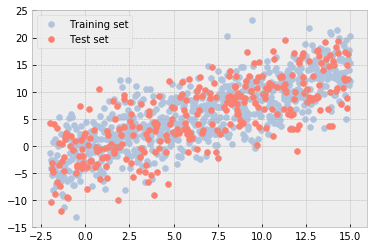

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib
import matplotlib.pyplot as plt
from numpy.random import normal
plt.style.use('bmh')
%matplotlib inline

np.random.seed(3)

x = np.linspace(start = -2, stop=15, num=1000)
intercept, x_coef = -1, 1
y = [x_coef*i + intercept for i in x]
y = [i+normal(0, 4) for i in y]

data = pd.DataFrame({'x': x, 'y': y})

# Split the data into training/testing sets
train, test = train_test_split(data, test_size=0.3)
X_train, X_test = train.x, test.x

# Split the targets into training/testing sets
y_train, y_test = train.y, test.y

plt.scatter(X_train, y_train, color='lightsteelblue', label = 'Training set')
plt.scatter(X_test, y_test, color='salmon', label = 'Test set')
plt.legend()

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import pymc3 as pm
import theano
import numpy as np

np.random.seed(42)
pm.set_tt_rng(42)

# Build the PyMC3 model
with pm.Model() as model:
    # Define priors
    sigma = pm.HalfCauchy('sigma', beta=10, testval=1.)
    intercept = pm.Normal('intercept', 0, sigma=20)
    x_coeff = pm.Normal('coeff_x', 0, sigma=20)

    # Define likelihood
    likelihood = pm.Normal('y', mu=intercept + x_coeff * x,
                           sigma=sigma, observed=y)

with model:
    mean_field = pm.fit(n=100000, method='advi', )

Average Loss = 2,830.2: 100%|█████████▉| 99901/100000 [00:57<00:00, 1839.03it/s] Interrupted at 99,999 [99%]: Average Loss = 4,404.7


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c3c649cc0>,
      dtype=object)

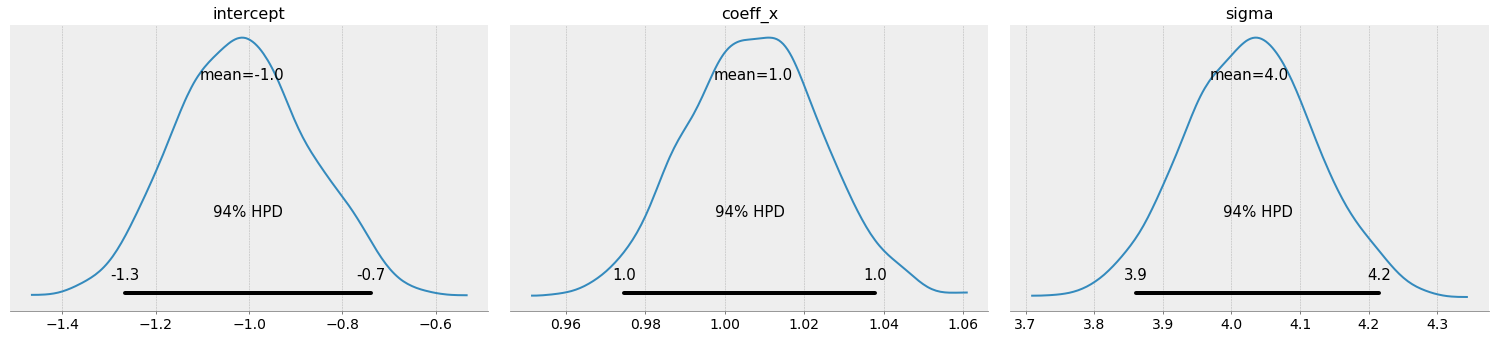

In [ ]:
# We then inspect the posterior distributions of the parameters in our model:
trace = mean_field.sample(2000)
pm.plot_posterior(trace, color='LightSeaGreen')

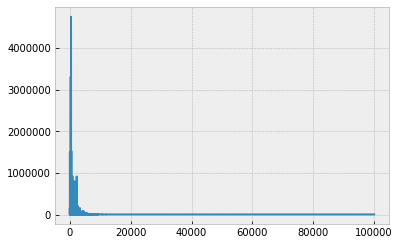

In [ ]:
# ... and check the algorithm for convergence
plt.plot(mean_field.hist)

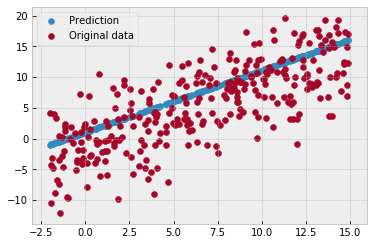

In [ ]:
# We now move to evaluating the results on the test set we created previously:

preds = np.subtract(np.multiply(X_test, trace['coeff_x'].mean()), trace['intercept'].mean())
plt.scatter(X_test, preds, label = 'Prediction')
plt.scatter(X_test, y_test, label = 'Original data')
plt.legend()

## 0.2 Black box variational inference for logistic regression

Let us now build a simple model to solve Bayesian logistic regression using black box variational inference. In this context,the probability $P(y_{i}/x_{i},z)$ is distributed as a Bernoulli random variable, whose parameter $p$ is determined by the latent variable $z$ and the input data $x$ ($Bern(\sigma(z^{T}x_i))$ which goes through a sigmoid ‘link’ function. According to the mean field approximation, the distribution of $q$ over $z$ ($q(z/\lambda)$ is equal to the product of conditionally independent normal distributions ($\prod _{j=1} ^{P} N(z_j/\mu_j, \sigma^2_j)$), each governed by parameters mu and sigma ($\lambda  = \{\mu_j, \sigma^2_j\}^P_{j=1}$).

Let us try to decompose the gradient of $L(\lambda)$ to show how we can evaluate it for logistic regression:

-$\Delta_{\lambda}logq(z/\lambda)$: we need to derive the gradient of $q$ w.r.t to $\mu$ and $\sigma$. We only report here the gradient of $\mu$ (the gradient of $\sigma$ can be derived in a similar way):

\begin{align}
\Delta_{\mu j}logq(z/\lambda) = \Delta_{\mu}\sum_{j=1}^P - \frac{log \sigma_j^2}{2} - \frac{(z_i - \mu_i)^2}{2\sigma_i^2} = \frac{z_j - \mu_j}{\sigma_j^2}
\end{align}

With the gradient of $q$ settled, the only term we are still missing (inside the gradient of the lower bound) is the joint distribution $log p(x, z)$. We observe that by using the chain rule of probability this expression is true: $logp(y,x,z) = logp(y/x,z) + logp(z)$. It is now easy to calculate the following expression that we can use for inference (remember the logistic regression loss formula):

\begin{align}
logp(y,x,z) = \sum_{i=1}^N[y_ilog\sigma(z^T x_i)+(1-y_i)(log(1-\sigma(z^Tx_i)))] + \sum_{j=1}^P log \phi(z_j / 0,1)
\end{align}

And to complete the ELBO expression:

\begin{align}
logq(z/\lambda) = \sum^P_{j=1}log \phi(z_j/\mu_j, \sigma^2_j)
\end{align}

So, in order to calculate the gradient of the lower bound we just need to sample from q(z/λ) (initialized with parameters mu and sigma) and evaluate the expression we have just derived (we could do this in Tensorflow by using ‘autodiff’ and passing a custom expression for gradient calculation)

We can solve this kind of problems without starting from scratch (although I think it is always beneficial (to try) to understand things from first principles). I will show you now how to run a Bayesian logistic regression model, i.e. how to turn the formulas you have seen above in executable Python code that uses Pymc3’s ADVI implementation as workhorse for optimization. What is remarkable here is that performing variational inference with Pymc3 is as easy as running MCMC, as we just need to specificy the functional form of the distribution to characterize.



In [ ]:
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
import numpy as np

def logistic(x, b, noise=None):
    L = x.T.dot(b)
    if noise is not None:
        L = L+noise
    return 1/(1+np.exp(-L))

x1 = np.linspace(-10., 10, 10000)
x2 = np.linspace(0., 20, 10000)
bias = np.ones(len(x1))
X = np.vstack([x1,x2,bias]) # Add intercept
B =  [-10., 2., 1.] # Sigmoid params for X + intercept

# Noisy mean
pnoisy = logistic(X, B, noise=np.random.normal(loc=0., scale=0., size=len(x1)))
# dichotomize pnoisy -- sample 0/1 with probability pnoisy
y = np.random.binomial(1., pnoisy)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [x2, x1, Intercept]
Sampling 2 chains: 100%|██████████| 7000/7000 [05:09<00:00,  8.51draws/s]
The number of effective samples is smaller than 25% for some parameters.


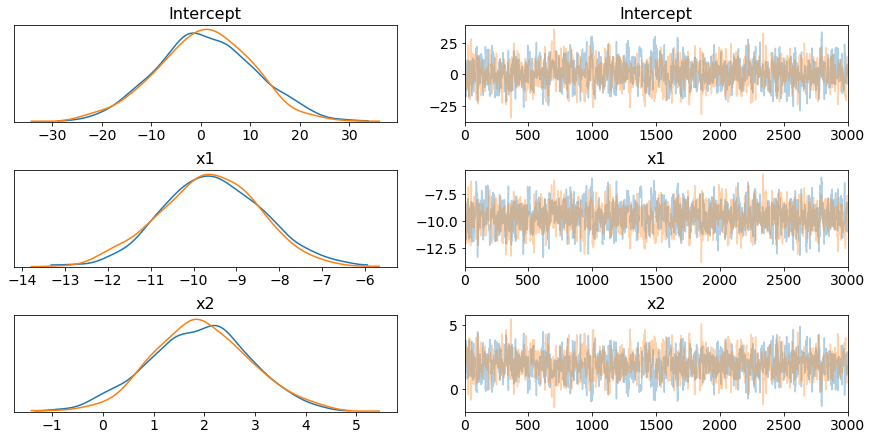

In [ ]:
with pm.Model() as model:
    # Define priors
    intercept = pm.Normal('Intercept', 0, sd=10)
    x1_coef = pm.Normal('x1', 0, sd=10)
    x2_coef = pm.Normal('x2', 0, sd=10)

    # Define likelihood
    likelihood = pm.Bernoulli('y',
           pm.math.sigmoid(intercept+x1_coef*X[0]+x2_coef*X[1]),
                          observed=y)
    trace = pm.sample(3000)
    pm.traceplot(trace) # plot results

The results are approximately what we expected: the maximum a posteriori (MAP) estimation coincides with the ‘beta’ parameters we used for data generation. Let us try now a minor modification to introduce ADVI inference in this example:

In [ ]:
# Code is the same as in previous code block, except for:
from pymc3.variational.callbacks import CheckParametersConvergence

with model:
    fit = pm.fit(100000, method='advi', callbacks=[CheckParametersConvergence()])
    # This will automatically check parameters convergence

draws = fit.sample(2000)

Average Loss = 239.08:  58%|█████▊    | 57864/100000 [00:57<00:35, 1180.86it/s]
Convergence achieved at 57900
Interrupted at 57,899 [57%]: Average Loss = 1,876.8


ADVI is considerably faster than NUTS, but what about accuracy? Instead of plotting bell curves again let us use this command to confront NUTS and ADVI results:



(<Figure size 576x712.8 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c288717b8>,
       dtype=object))

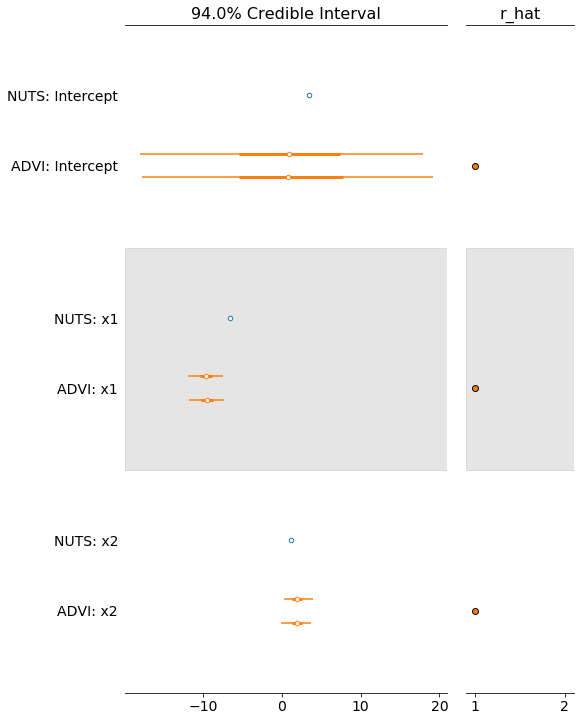

In [ ]:
import arviz as az
az.plot_forest([draws, trace], model_names = ['NUTS', 'ADVI'], r_hat = True)

ADVI is clearly underestimating the variance, but it is fairly close to the mean of each parameter. Let us try to visualize the covariance structure of the model to understand where this lack of precision may come from (a big thank to colcarroll for pointing this out):

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c2794f630>,
      dtype=object)

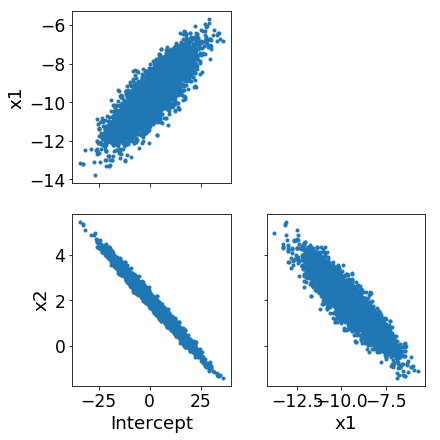

In [ ]:
az.plot_pair(trace, figsize=(6, 6)) # Covariance plots for the NUTS trace

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c28cb6f98>,
      dtype=object)

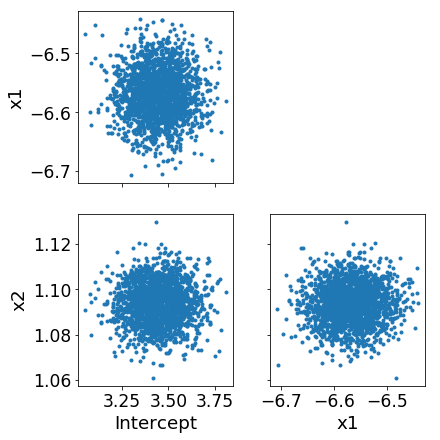

In [ ]:
az.plot_pair(draws, figsize=(6, 6)) # Covariance plots for the ADVI trace

The classical ADVI implementation does not capture the interactions between variables because of the mean field approximation, and so it underestimates the overall variance by far (be advised: this is a particularly tricky example chosen to highlight this kind of behavior).
Also, in order to capture the correlations we are seeing we could try to set method='fullrank_advi', although estimating off-diagonal terms (the correlation between latent variables) may become computationally too expensive.

## 0.3 Gaussian mixture model with ADVI

In this recipe we will revisit a model most people are already familiar with due to the EM algorithm, the famous Gaussian Mixture Models (GMMs). Again, in order to use Variation Inference, the generative model does not need to be changed, we just need to call the fit function with different parameters. We will appreciate the superior (computational) performance of ADVI when estimating distribution parameters which is attained thanks to the approximations outlined in the previous chapter.

Let us start by simulating a GMM in tridimensional space with two components:

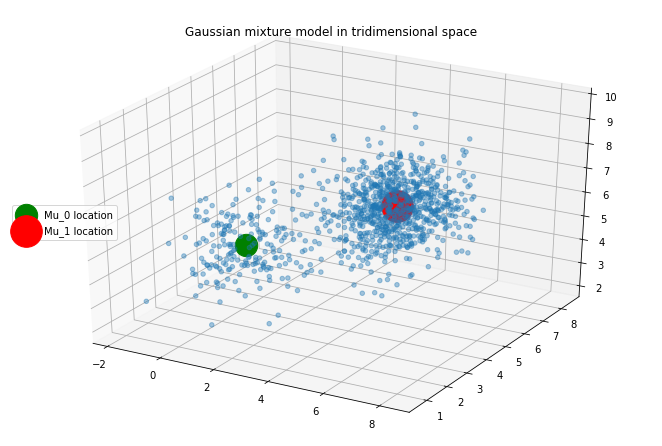

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def sample_bernoulli(p = 0.8):
    return np.random.binomial(size=1, n=1, p= p)[0]

def sample_multivariate_normal(mus, stds):
    return np.random.multivariate_normal(mean = mus, cov = stds, size = 1)[0]

n_samples = 100
mus = [[1, 3, 5], [5, 5, 6.5]]

data = np.array([sample_multivariate_normal(mus[sample_bernoulli()],
                                            stds=np.eye(3)) for i in range(1000)])

fig = plt.figure(figsize=(9, 6))
ax = Axes3D(fig)
ax.scatter(1, 3, 5, c='g', s=500, label = 'Mu_0 location')
ax.scatter(5, 5, 6.5, c='r', s=1000, label = 'Mu_1 location')
cset = ax.scatter(data.T[0, :], data.T[1, :], data.T[2, :], alpha = 0.4)
plt.title('Gaussian mixture model in tridimensional space')
plt.legend(loc = "center left")
plt.show()

In [ ]:
from pymc3.math import logsumexp
from pymc3.math import logsumexp
import pymc3 as pm
from pymc3 import Normal, Metropolis, sample, MvNormal, Dirichlet, \
    DensityDist, find_MAP, NUTS, Slice
import theano.tensor as tt
from theano.tensor.nlinalg import det
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(0)

# Log likelihood of normal distribution
def logp_normal(mu, tau, value):
    # log probability of individual samples, could probably substitute this with built-in functions
    k = tau.shape[0]
    delta = lambda mu: value - mu
    return (-1 / 2.) * (k * tt.log(2 * np.pi) + tt.log(1./det(tau)) +
                         (delta(mu).dot(tau) * delta(mu)).sum(axis=1))

# Log likelihood of Gaussian mixture distribution
def logp_gmix(mus, pi, tau):
    def logp_(value):
        logps = [tt.log(pi[i]) + logp_normal(mu, tau, value)
                 for i, mu in enumerate(mus)]

        return tt.sum(logsumexp(tt.stacklists(logps)[:, :n_samples], axis=0))

    return logp_

# Model definition: create 2 multivariate normal random variables and a categorical variable (cluster loadings) using Dirichlet
with pm.Model() as model:
    # Gaussian priors definition
    mus = [MvNormal('mu_%d' % i,
                    mu=pm.floatX(np.zeros(3)),
                    tau=pm.floatX(0.1 * np.eye(3)),
                    shape=(3,))
           for i in range(2)]
    # Cluster loadings priors (Dirichlet)
    pi = Dirichlet('pi', a=pm.floatX(0.1 * np.ones(2)), shape=(2,))
    # Define the likelihood
    xs = DensityDist('x', logp_gmix(mus, pi, np.eye(3)), observed=data)

In [ ]:
# Find Maximum A Posteriori estimates for params
with model:
    start = find_MAP()
    step = Metropolis()
    trace = sample(3000, step, start=start)

logp = -4,474.9, ||grad|| = 626.41: 100%|██████████| 5/5 [00:00<00:00, 794.92it/s]
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [pi]
>Metropolis: [mu_1]
>Metropolis: [mu_0]
Sampling 2 chains: 100%|██████████| 7000/7000 [00:04<00:00, 1747.02draws/s]
The number of effective samples is smaller than 10% for some parameters.


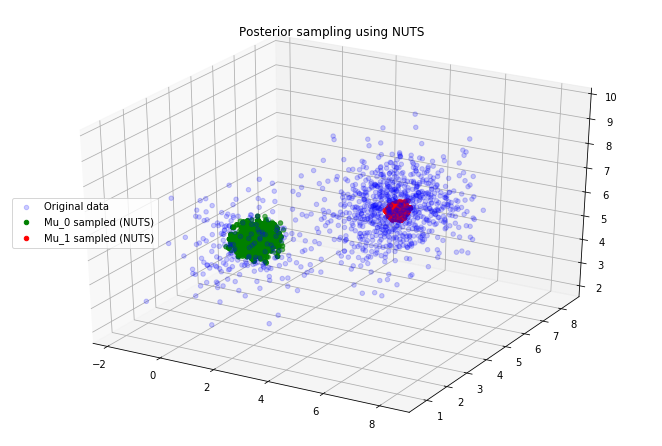

In [ ]:
fig = plt.figure(figsize=(9, 6))
ax = Axes3D(fig)

mu_0, mu_1 = trace['mu_0'], trace['mu_1']
ax.scatter(data.T[0, :], data.T[1, :], data.T[2, :], alpha = 0.2, c = 'b', label = 'Original data')
ax.scatter(mu_0[:, 0], mu_0[:, 1], mu_0[:, 2], c = 'g', label = 'Mu_0 sampled (NUTS)')
ax.scatter(mu_1[:, 0], mu_1[:, 1], mu_1[:, 2], c = 'r', label = 'Mu_1 sampled (NUTS)')

plt.title('Posterior sampling using NUTS')
plt.legend(loc = "center left")
plt.show()

In [ ]:
# Let's start over again and redefine our model and fit using ADVI
with pm.Model() as model:
    mus = [MvNormal('mu_%d' % i,
                    mu=pm.floatX(np.zeros(3)),
                    tau=pm.floatX(0.1 * np.eye(3)),
                    shape=(3,))
           for i in range(2)]
    pi = Dirichlet('pi', a=pm.floatX(0.1 * np.ones(2)), shape=(2,))
    xs = DensityDist('x', logp_gmix(mus, pi, np.eye(3)), observed=data)


with model:
    %time approx = pm.fit(n=10000, method = 'advi', obj_optimizer=pm.adagrad(learning_rate=1e-1))

Average Loss = 481.89: 100%|██████████| 10000/10000 [00:10<00:00, 990.91it/s] 
Finished [100%]: Average Loss = 481.83


CPU times: user 9.99 s, sys: 1.47 s, total: 11.5 s
Wall time: 12.4 s


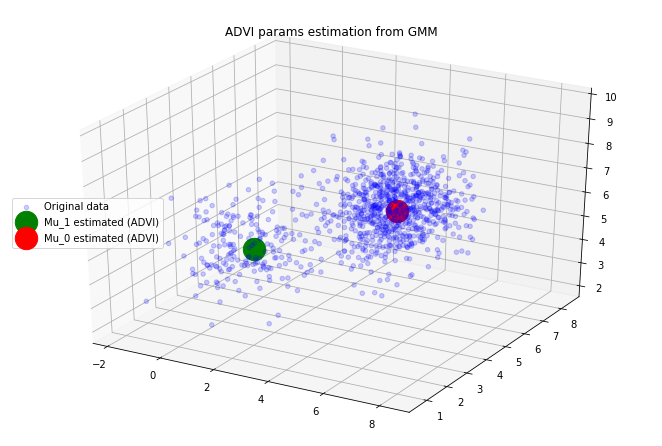

In [ ]:
# Extract Gaussian means after fitting the model with ADVI
means = approx.bij.rmap(approx.mean.eval())

fig = plt.figure(figsize=(9, 6))
ax = Axes3D(fig)

ax.scatter(data.T[0, :], data.T[1, :], data.T[2, :], alpha = 0.2, c = 'b', label = 'Original data')
ax.scatter(means['mu_0'][0], means['mu_0'][1], means['mu_0'][2], s= 500, c = 'g', label = 'Mu_1 estimated (ADVI)')
ax.scatter(means['mu_1'][0], means['mu_1'][1], means['mu_1'][2], s= 500, c = 'r', label = 'Mu_0 estimated (ADVI)')

plt.title('ADVI params (mus) estimation from GMM')
plt.legend(loc = "center left")
plt.show()

(<Figure size 576x820.8 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c398f8080>,
       dtype=object))

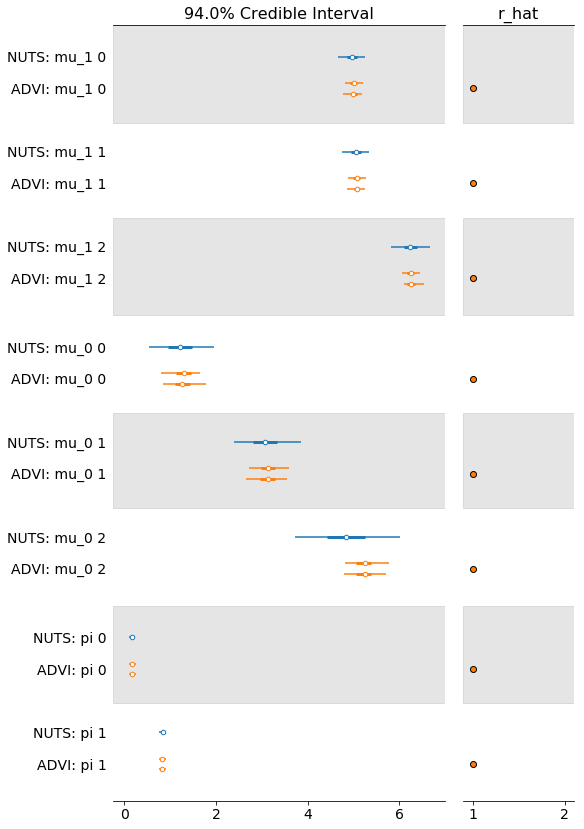

In [ ]:
# Let's now check the estimates we get for each component of the tridimensional space
import arviz as az
az.plot_forest([approx.sample(2000) , trace],
               model_names = ['NUTS', 'ADVI'], r_hat = True)

\* Of course if you execute multiple times this last cell the label attributions (mu_0, mu_1) between the two different models may be inverted

## 0.4 Mini-batch variational inference on hierarchical regression model

Let us now use a similar approach to fit a more complicated model. You may have read about the 'radon' dataset (which is often used in the context of hierarchical regression models). I'll just post here a description of the dataset (https://docs.pymc.io/notebooks/multilevel_modeling.html) you can refer to when following along the next few cells.

In [ ]:
%matplotlib inline
%env THEANO_FLAGS=device=cpu, floatX=float32, warn_float64=ignore
import theano
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import pandas as pd

data = pd.read_csv(pm.get_data('radon.csv'))

county_names = data.county.unique()
county_idx = data['county_code'].values
n_counties = len(data.county.unique())
total_size = len(data)

env: THEANO_FLAGS=device=cpu, floatX=float32, warn_float64=ignore


In [ ]:
import theano.tensor as tt

# Use the 'Minibatch' PyMC3 function in order to speed up computation.
# You just need to wrap your dataset with this function in order to make it work
log_radon_t = pm.Minibatch(data.log_radon.values, 100)
floor_t = pm.Minibatch(data.floor.values, 100)
county_idx_t = pm.Minibatch(data.county_code.values, 100)

/Users/arrigon5/anaconda3/lib/python3.7/site-packages/pymc3/data.py:245: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.shared = theano.shared(data[in_memory_slc])
/Users/arrigon5/anaconda3/lib/python3.7/site-packages/pymc3/data.py:245: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.shared = theano.shared(data[in_memory_slc])


In [ ]:
# Scroll down a few cells to visualize the place notation for this model
with pm.Model() as hierarchical_model:
    # Hyperpriors for group nodes
    mu_a = pm.Normal('mu_alpha', mu=0., sigma=100**2)
    sigma_a = pm.Uniform('sigma_alpha', lower=0, upper=100)
    mu_b = pm.Normal('mu_beta', mu=0., sigma=100**2)
    sigma_b = pm.Uniform('sigma_beta', lower=0, upper=100)

In [ ]:
with hierarchical_model:

    a = pm.Normal('alpha', mu=mu_a, sigma=sigma_a, shape=n_counties)
    # Intercept for each county, distributed around group mean mu_a
    b = pm.Normal('beta', mu=mu_b, sigma=sigma_b, shape=n_counties)

In [ ]:
with hierarchical_model:
    radon_est = a[county_idx_t] + b[county_idx_t] * floor_t

In [ ]:
with hierarchical_model:

    # Model error
    eps = pm.Uniform('eps', lower=0, upper=100)

    # Data likelihood
    radon_like = pm.Normal('radon_like', mu=radon_est, sigma=eps, observed=log_radon_t, total_size=len(data))

In [ ]:
with hierarchical_model:
    approx = pm.fit(100000, method = 'advi', callbacks=[pm.callbacks.CheckParametersConvergence(tolerance=1e-4)])

Average Loss = 120.49: 100%|██████████| 100000/100000 [01:11<00:00, 1399.49it/s]
Finished [100%]: Average Loss = 120.53


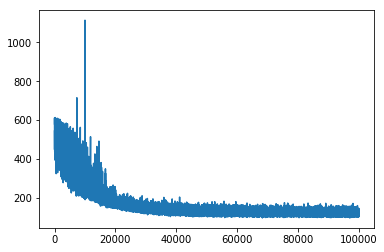

In [ ]:
import matplotlib.pyplot as plt
plt.plot(approx.hist);

In [ ]:
means = approx.bij.rmap(approx.mean.eval())
sds = approx.bij.rmap(approx.std.eval())

(<Figure size 432x1584 with 1 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c29a33b00>],
       dtype=object))

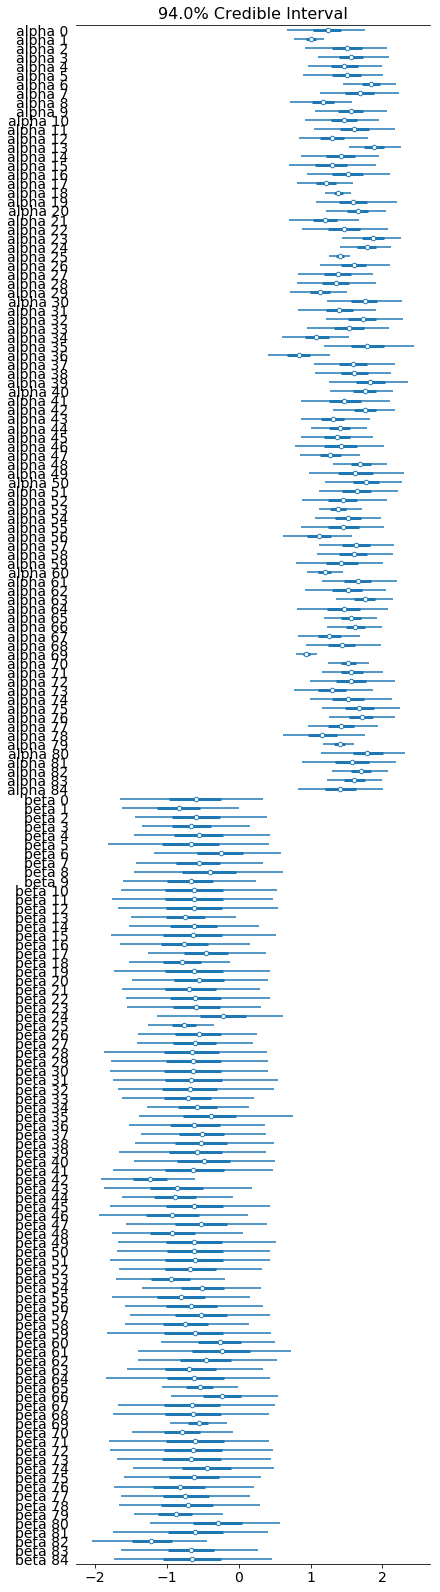

In [ ]:
import arviz as az
trace_approx = approx.sample(2000)
az.plot_forest(trace_approx, var_names=['alpha','beta'])

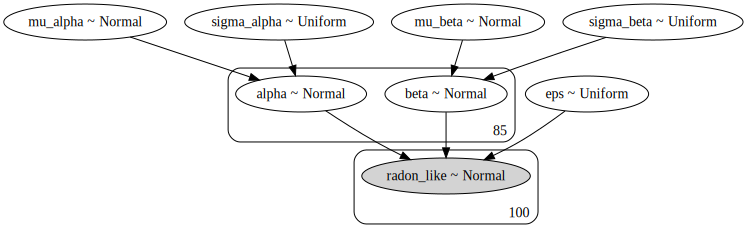

In [ ]:
from pymc3 import model_to_graphviz

model_to_graphviz(hierarchical_model)

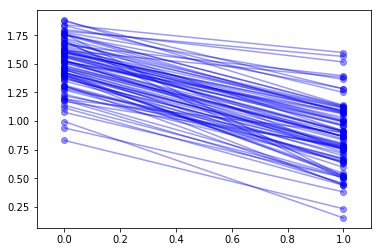

In [ ]:
# Does the floor influence radon levels?

xvals = np.arange(2)
b = means['alpha']
m = means['beta']
for bi,mi in zip(b,m):
    plt.plot(xvals, mi*xvals + bi, 'bo-', alpha=0.4)
plt.xlim(-0.1, 1.1);

## 0.5 Bayesian neural networks


In [ ]:
from sklearn.datasets import make_circles
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
import theano
floatX = theano.config.floatX
import pymc3 as pm
import theano.tensor as T
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')
%matplotlib inline
plt.style.use('bmh')
plt.rcParams["figure.figsize"] = (9,6)
plt.rcParams["font.size"] = "15"

Text(0.5, 1.0, 'Dataset to test non-linear binary separation \n performance of the model')

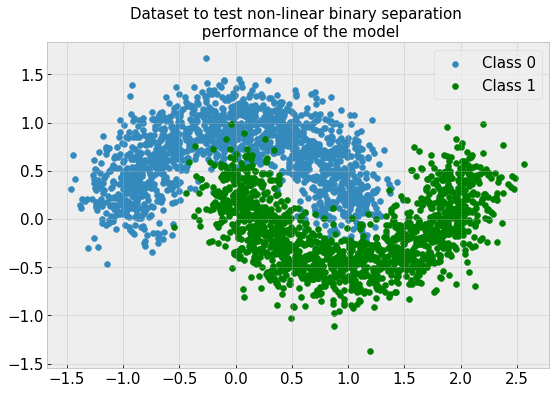

In [ ]:
# Let's create a simple dataset of non-linearly separable points in a bidimensional space

coordinates, label = make_moons(n_samples = 3000, noise=0.2)
X = pd.DataFrame(coordinates)
X.columns = ['x_axis', 'y_axis']
X['label'] = label
plt.scatter(x = X[X.label == 0].x_axis,
            y = X[X.label == 0].y_axis, label = 'Class 0')
plt.scatter(x = X[X.label == 1].x_axis,
            y = X[X.label == 1].y_axis, c = 'g', label = 'Class 1')
plt.legend()
plt.title('Dataset to test non-linear binary separation \n performance of the model', fontsize=15)

In [ ]:
# Scale dataset
X = scale(coordinates)
X = X.astype(floatX)
Y = label.astype(floatX)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.5)

In [ ]:
# This is one of the few cases where seeing the model in plate notation does not help anymore than seeing the
# model laid out in a context manager :)

def construct_nn(ann_input, ann_output):
    n_hidden = 5

    # Initialize random weights between each layer
    init_1 = np.random.randn(X.shape[1], n_hidden).astype(floatX)
    init_2 = np.random.randn(n_hidden, n_hidden).astype(floatX)
    init_3 = np.random.randn(n_hidden, n_hidden).astype(floatX)
    init_out = np.random.randn(n_hidden).astype(floatX)

    with pm.Model() as neural_network:
        ann_input = pm.Data('ann_input', X_train)
        ann_output = pm.Data('ann_output', Y_train)

        # Weights from input to hidden layer
        weights_in_1 = pm.Normal('w_in_1', 0, sigma=1,
                                 shape=(X.shape[1], n_hidden),
                                 testval=init_1)

        # Weights from 1st to 2nd layer
        weights_1_2 = pm.Normal('w_1_2', 0, sigma=1,
                                shape=(n_hidden, n_hidden),
                                testval=init_2)

        # Weights from 2nd to 3rd layer
        weights_2_3 = pm.Normal('w_2_3', 0, sigma=1,
                                shape=(n_hidden, n_hidden),
                                testval=init_3)

        # Weights from hidden layer to output
        weights_3_out = pm.Normal('w_3_out', 0, sigma=1,
                                  shape=(n_hidden,),
                                  testval=init_out)

        # Build neural-network using tanh activation function
        act_1 = pm.math.tanh(pm.math.dot(ann_input,
                                         weights_in_1))
        act_2 = pm.math.tanh(pm.math.dot(act_1,
                                         weights_1_2))
        act_3 = pm.math.tanh(pm.math.dot(act_2,
                                         weights_2_3))
        act_out = pm.math.sigmoid(pm.math.dot(act_3,
                                              weights_3_out))

        # Binary classification -> Bernoulli likelihood
        out = pm.Bernoulli('out',
                           act_out,
                           observed=ann_output,
                          )
    return neural_network

neural_network = construct_nn(X_train, Y_train)

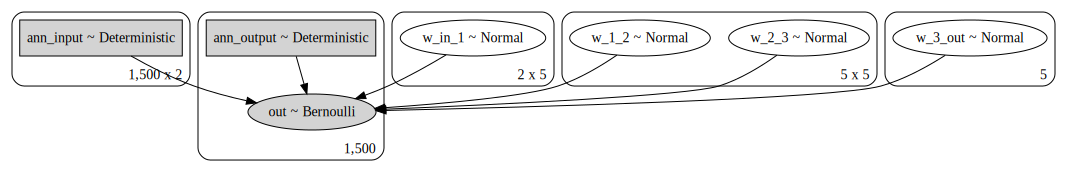

In [ ]:
pm.model_to_graphviz(neural_network)

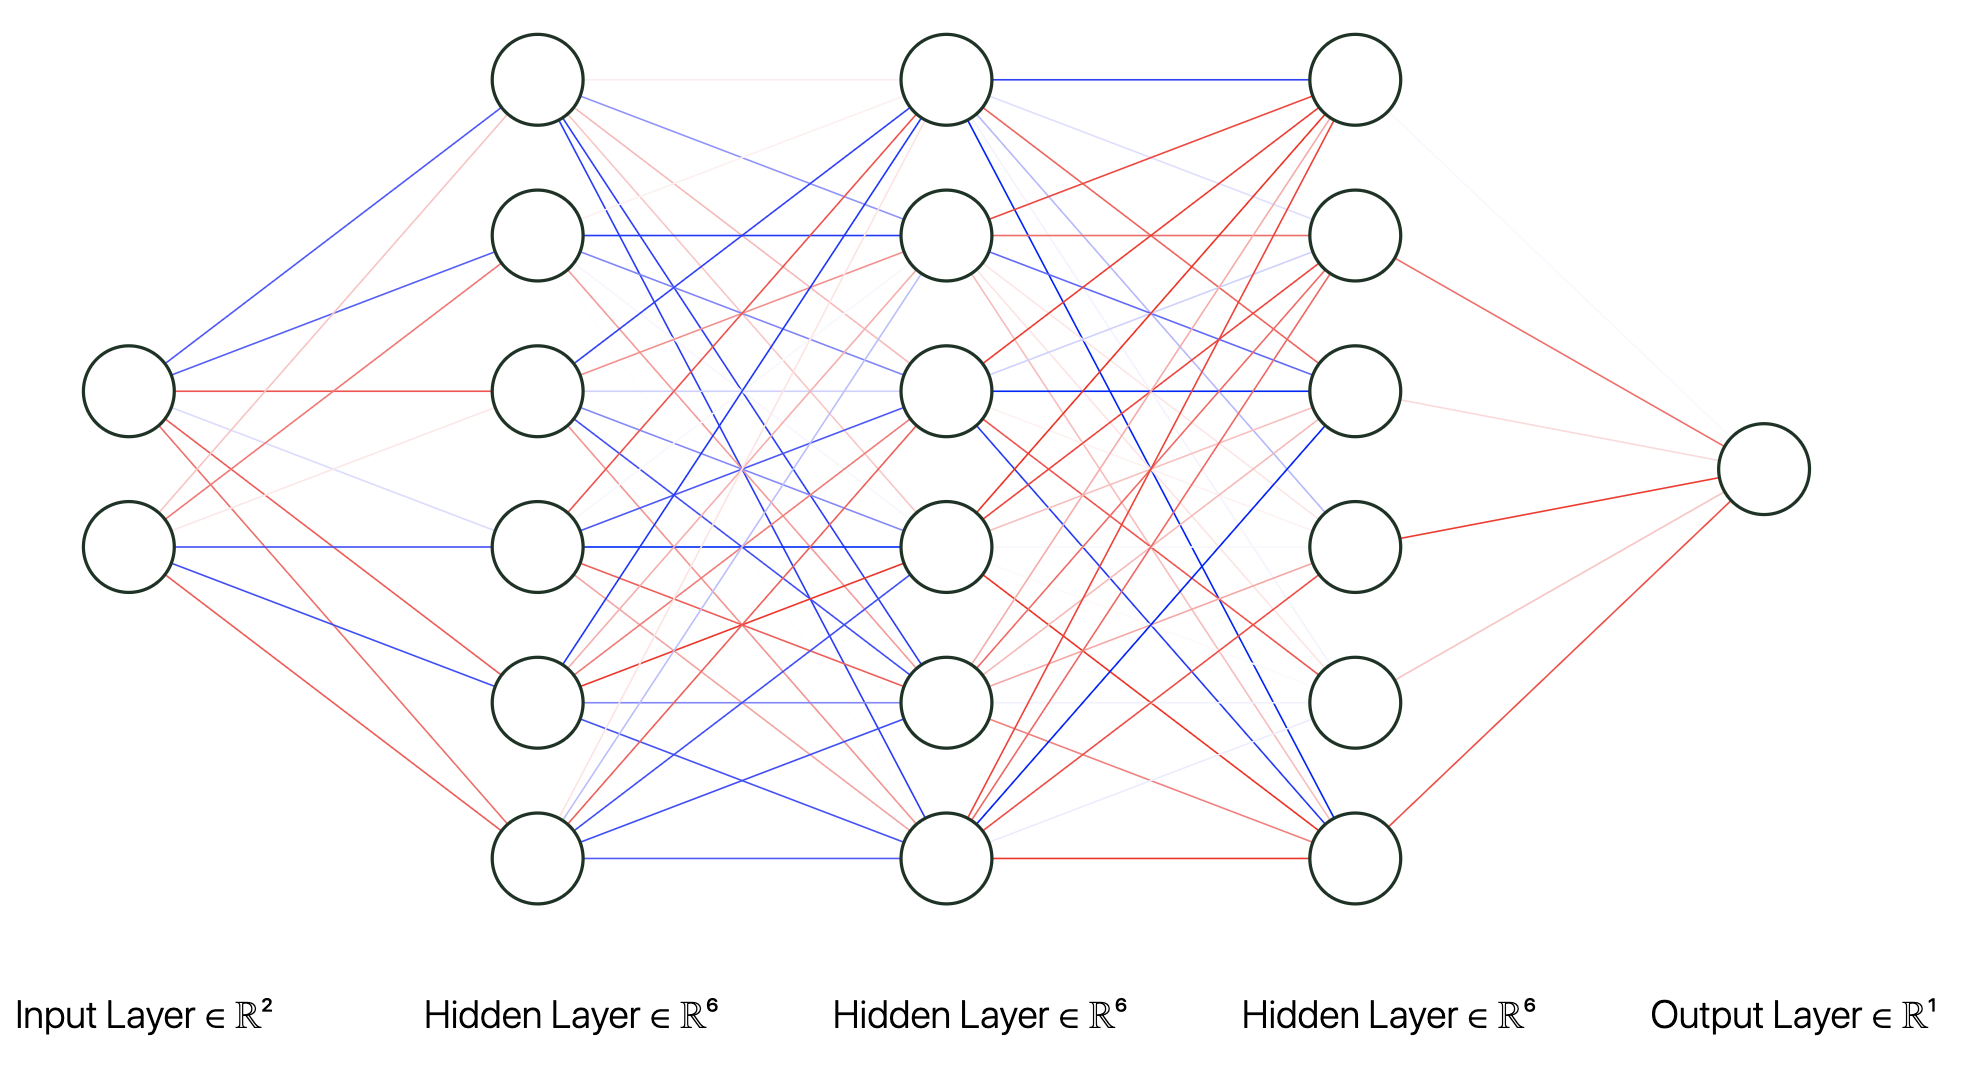

In [ ]:
from IPython.display import display
from PIL import Image


path="net_structure.png"
display(Image.open(path))

In [ ]:
# We are now familiar with this command:
with neural_network:
    approx = pm.fit(n=100000, method='advi')


Average Loss = 230.39: 100%|██████████| 100000/100000 [01:51<00:00, 895.71it/s]
Finished [100%]: Average Loss = 230.38


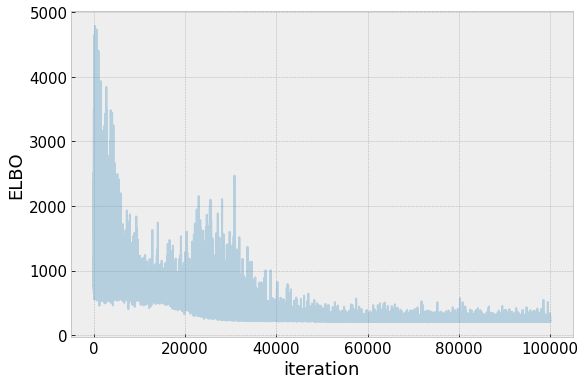

In [ ]:
plt.plot(approx.hist, alpha=.3)
plt.ylabel('ELBO')
plt.xlabel('iteration');

In [ ]:
trace = approx.sample(draws=5000)

In [ ]:
# create symbolic input
x = T.matrix('X')
# symbolic number of samples is supported, we build vectorized posterior on the fly
n = T.iscalar('n')
# Do not forget test_values or set theano.config.compute_test_value = 'off'
x.tag.test_value = np.empty_like(X_train[:10])
n.tag.test_value = 100
_sample_proba = approx.sample_node(neural_network.out.distribution.p,
                                   size=n,
                                   more_replacements={neural_network['ann_input']: x})
# It is time to compile the function
sample_proba = theano.function([x, n], _sample_proba)

In [ ]:
# Let's get results by subsetting with an (adjustable) threshold of 0.5
pred = sample_proba(X_test, 500).mean(0) > 0.5

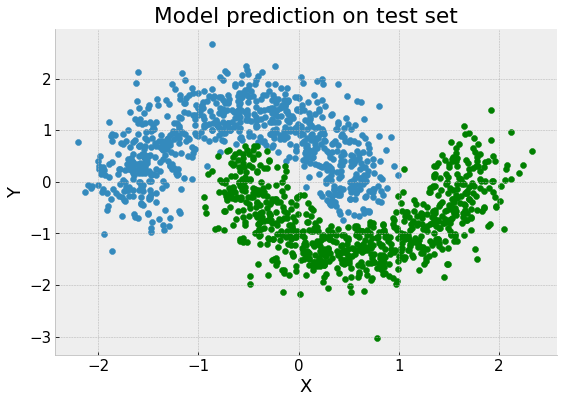

In [ ]:
fig, ax = plt.subplots()
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='g')
sns.despine()
ax.set(title='Model prediction on test set', xlabel='X', ylabel='Y');

In [ ]:
print('Accuracy = {}%'.format((Y_test == pred).mean() * 100))

Accuracy = 97.39999999999999%
